In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Set MLflow experiment
mlflow.set_experiment("House Price Prediction")


<Experiment: artifact_location='file:///c:/Users/ayush/OneDrive/Desktop/MLOps%20Lab/mlruns/185263012116731052', creation_time=1762361746143, experiment_id='185263012116731052', last_update_time=1762361746143, lifecycle_stage='active', name='House Price Prediction', tags={}>

In [11]:
# =====================
# STEP 1 — Load Dataset
# =====================
def load_data(path="HPPD.csv"):
    df = pd.read_csv(path)
    df = df.dropna()
    return df


In [12]:
# Examine dataset structure
df = pd.read_csv("HPPD.csv")
print("Dataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
df.info()

Dataset columns:
['Id', 'Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt', 'Location', 'Condition', 'Garage', 'Price']

First few rows:
   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970  Downtown  Excellent   
1   2  4272         5          4       3       1958  Downtown  Excellent   
2   3  3592         2          2       3       1938  Downtown       Good   
3   4   966         4          2       2       1902  Suburban       Fair   
4   5  4926         1          4       2       1975  Downtown       Fair   

  Garage   Price  
0     No  149919  
1     No  424998  
2     No  266746  
3    Yes  244020  
4    Yes  636056  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedro

In [13]:
# STEP 2 — Preprocessing
# =====================
def preprocess_data(df):
    # Print available columns for debugging
    print("Available columns:", df.columns.tolist())
    
    # Convert column names to lowercase for consistency
    df.columns = df.columns.str.lower()
    
    # Identify numeric columns automatically
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Identify the target column (assuming it contains 'price' in the name)
    price_column = [col for col in numeric_columns if 'price' in col.lower()]
    if not price_column:
        raise ValueError("No price column found in the dataset!")
    target_column = price_column[0]
    
    # Remove target column from features
    features = [col for col in numeric_columns if col != target_column]
    
    print(f"Target column: {target_column}")
    print(f"Feature columns: {features}")
    
    # Select features and target
    X = df[features]
    y = df[target_column]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y, scaler

In [14]:
# STEP 3 — Train Model
# =====================
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Define hyperparameters to track
    params = {
        "n_estimators": 100,
        "max_depth": 10,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42
    }

    with mlflow.start_run():
        # Log parameters
        mlflow.log_params(params)
        
        # Train model
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)

        # Make predictions
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        test_mae = mean_absolute_error(y_test, test_preds)
        test_r2 = r2_score(y_test, test_preds)

        # Log metrics
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_r2", test_r2)

        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        # Log feature importance plot
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title('Feature Importance')
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "feature_importance.png")
        plt.close()

    print(f"✅ Model trained successfully!")
    print(f"Train RMSE: ${train_rmse:,.2f}")
    print(f"Test RMSE: ${test_rmse:,.2f}")
    print(f"Test MAE: ${test_mae:,.2f}")
    print(f"Test R²: {test_r2:.3f}")
    
    return model

In [15]:
# STEP 4 — Visualization
# =====================
def visualize_predictions(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    preds = model.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.5, color="blue", label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label="Perfect Prediction")
    plt.xlabel("Actual House Prices ($)")
    plt.ylabel("Predicted House Prices ($)")
    plt.title("Actual vs Predicted House Prices")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Available columns: ['Id', 'Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt', 'Location', 'Condition', 'Garage', 'Price']
Target column: price
Feature columns: ['id', 'area', 'bedrooms', 'bathrooms', 'floors', 'yearbuilt']


2025/11/05 22:50:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/05 22:51:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Model trained successfully!
Train RMSE: $204,562.30
Test RMSE: $283,573.90
Test MAE: $246,664.42
Test R²: -0.034


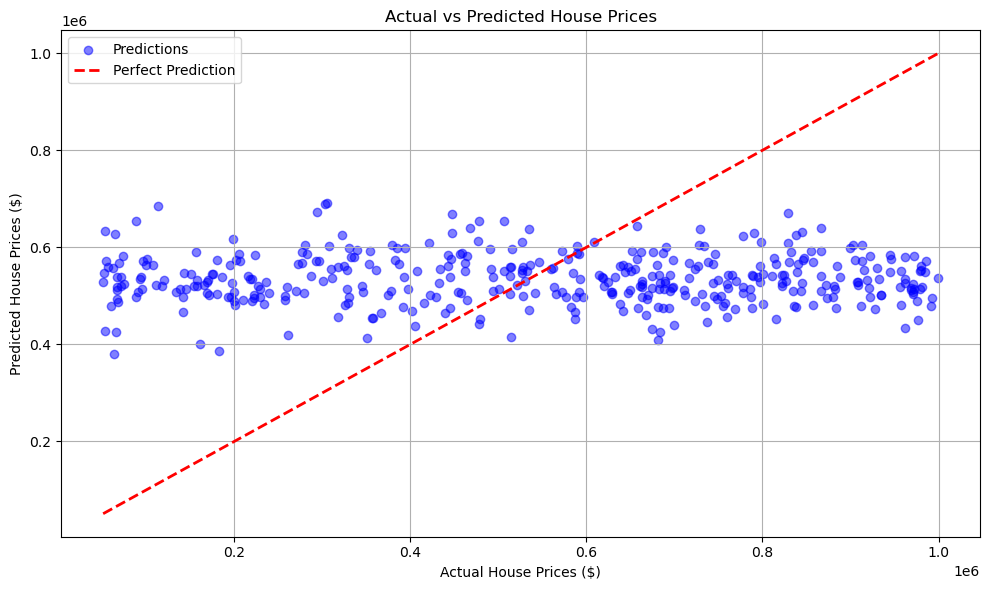

✅ Model and scaler saved successfully.


In [16]:
# Run Training Pipeline
# =====================
df = load_data("HPPD.csv")
X, y, scaler = preprocess_data(df)
model = train_model(X, y)

# Optional visualization
visualize_predictions(model, X, y)

# Save model and scaler for deployment
import joblib
joblib.dump(model, "house_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved successfully.")